In [21]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
image= cv2.imread('original.png')


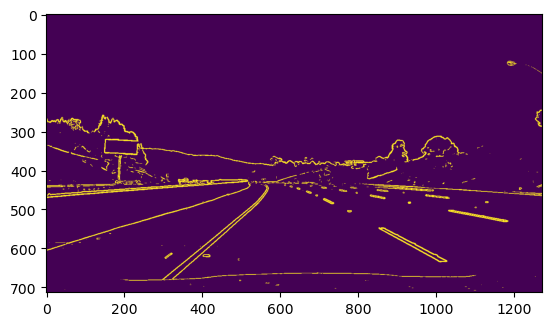

In [23]:
def Sobel(frame,threshold1=50):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8((sobel / np.max(sobel)) * 255)
    _, sobel = cv2.threshold(sobel, threshold1, 255, cv2.THRESH_BINARY)
    return sobel    
lanes_sobel= Sobel(image)
plt.imshow(lanes_sobel)
plt.show()            

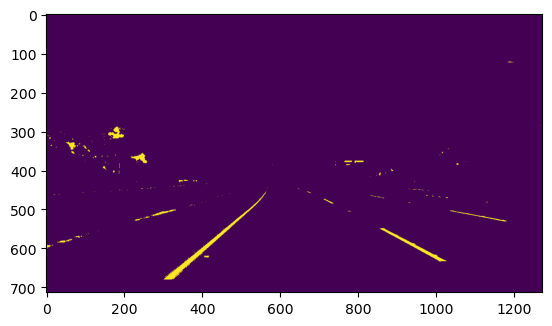

In [24]:
def detect_lanes_by_color(frame):
    hls=cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
    sChannel=hls[:,:,2]
    lchannel=hls[:,:,1]
    l_min=200
    l_max=255
    s_min=170
    s_max=255
    mask= np.zeros_like(sChannel)
    mask[(sChannel >= s_min) & (sChannel <= s_max)] = 255
    mask[(lchannel >= l_min) & (lchannel <= l_max)] = 255
    return mask

lanes_color=detect_lanes_by_color(image)
plt.imshow(lanes_color)
plt.show()

In [25]:
def combine_lanes(lanes_color, lanes_sobel):
    combined = cv2.bitwise_or(lanes_color, lanes_sobel)
    return combined

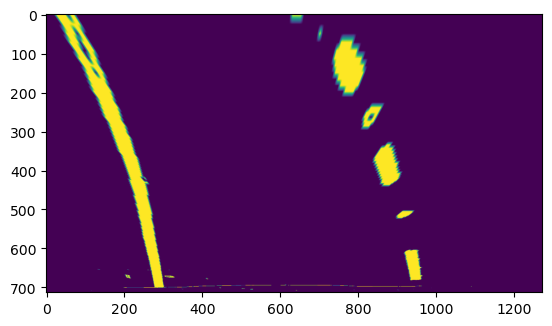

In [ ]:
def prespective_transform(image):
    img_size = (image.shape[1], image.shape[0])  
    # this should be changed to be tuned with the camera and the road
    src = np.float32( 
        [[685, 450],
          [1090, 710],
          [220, 710],
          [595, 450]])

    dst = np.float32(
        [[900, 0],
          [900, 710],
          [250, 710],
          [250, 0]])
    matrix = cv2.getPerspectiveTransform(src, dst)
    inv_matrix =cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, matrix,img_size, flags=cv2.INTER_LINEAR)
    return warped, inv_matrix

combied_binary = combine_lanes(lanes_color, lanes_sobel)
warped, Minv = prespective_transform(combied_binary)
plt.imshow(warped)
plt.show()

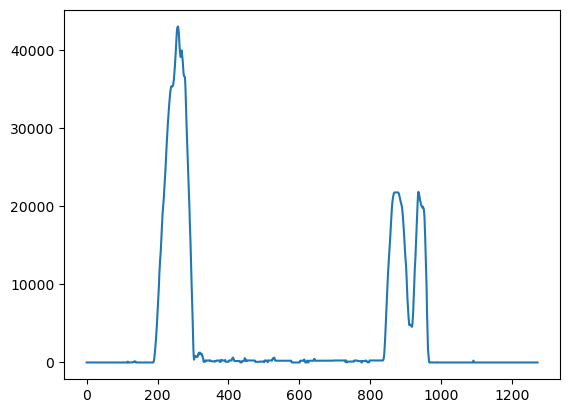

In [27]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    return histogram


histogram = get_histogram(warped)
plt.plot(histogram)
plt.show()

In [28]:
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = binary_warped.shape[0] // nwindows
    margin = 100
    minpix = 50

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left = (
            (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
        ).nonzero()[0]

        good_right = (
            (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
        ).nonzero()[0]

        left_lane_inds.append(good_left)
        right_lane_inds.append(good_right)

        if len(good_left) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left]))
        if len(good_right) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

leftx, lefty, rightx, righty = sliding_window(warped)


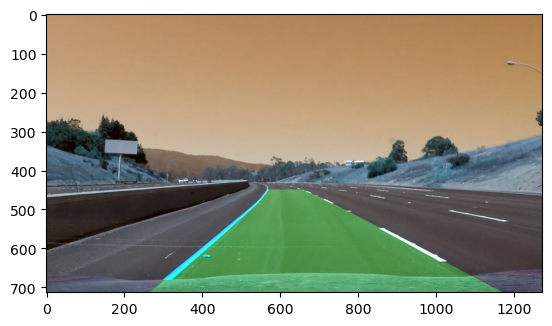

In [29]:
image = cv2.imread('original.png')
def draw_lanes(original, binary_warped, Minv, left_fit, right_fit):
    h, w = binary_warped.shape

    ploty = np.linspace(0, h - 1, h)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    color_warp = np.zeros((h, w, 3), dtype=np.uint8)

    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int32([pts]), (0, 255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)

    return result

if len(leftx) > 0 and len(rightx) > 0:
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    result = draw_lanes(image, warped, Minv, left_fit, right_fit)
    plt.imshow(result)
    plt.show()

In [ ]:
#this should be changed to be the video from the camera
cap = cv2.VideoCapture("road.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    lanes_color = detect_lanes_by_color(frame)
    lanes_sobel = Sobel(frame)
    combined_binary = combine_lanes(lanes_color, lanes_sobel)
    warped, Minv = prespective_transform(combined_binary)

    leftx, lefty, rightx, righty = sliding_window(warped)

    if len(leftx) > 0 and len(rightx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        result = draw_lanes(frame, warped, Minv, left_fit, right_fit)
        cv2.imshow("Lane Detection", result)
    else:
        cv2.imshow("Lane Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
